# School Explorer Preliminary EDA / Cleaning Notebook
[Return to project overview](final_project_overview.ipynb)

### Andrew Larimer, Deepak Nagaraj, Daniel Olmstead, Michael Winton (W207-4-Summer 2018 Final Project)

The [2016 School Explorer](https://www.kaggle.com/passnyc/data-science-for-good#2016%20School%20Explorer.csv) dataset includes highly detailed information about all 1200+ schools in the five boroughs of New York.  This information includes:

* Physical information like grade, latitude/longitude, district, location and SED codes, etc.
* Descriptive information such as Grades, whether it is a community school
* Financial information such as Budget, Economic Need Index
* Demographic information such as percent Asian, Black, etc., percent ELL
* School program information such as Rigorous Instruction, Collaborative Teachers, Supportive Environment, etc.
* Academic achievement information in the form of per-grade and per-economic/demographic breakdowns of number of Math/ELA students who receive scores of '4' (highest score)


In [1]:
# import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# set default options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

%matplotlib inline

In [2]:
# load dataset from CSV
raw_se_2016 = pd.read_csv('data_raw/2016_school_explorer.csv')
raw_se_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1272 entries, 0 to 1271
Columns: 161 entries, Adjusted Grade to Grade 8 Math 4s - Economically Disadvantaged
dtypes: float64(5), int64(123), object(33)
memory usage: 1.6+ MB


## Trimming
There is considerably more here than we need, starting with the fact that the dataset includes primary schools that only go up to 5th grade.  We trim the dataset to only those schools that have a 7th grade.

In [3]:
se_2016_trimmed = raw_se_2016[raw_se_2016['Grades'].str.contains('07')]
se_2016_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 596 entries, 3 to 1269
Columns: 161 entries, Adjusted Grade to Grade 8 Math 4s - Economically Disadvantaged
dtypes: float64(5), int64(123), object(33)
memory usage: 754.3+ KB


This cuts the number of entries roughly in half, but there are also many more columns than we need.  We want to keep the information that describes the school's location, practices and demographics, and the academic descriptors of the 7th grade (these students will take the SHSAT exam in the fall of their 8th grade).

In [4]:
features_to_keep = ['Location Code', 'School Name', 'District','Zip', 'Community School?', 'Economic Need Index', 'School Income Estimate',
                    'Percent ELL', 'Percent Asian', 'Percent Black', 'Percent Hispanic',
                    'Percent Black / Hispanic', 'Percent White', 'Student Attendance Rate',
                    'Percent of Students Chronically Absent', 'Rigorous Instruction %',
                    'Rigorous Instruction Rating', 'Collaborative Teachers %',
                    'Collaborative Teachers Rating', 'Supportive Environment %',
                    'Supportive Environment Rating', 'Effective School Leadership %',
                    'Effective School Leadership Rating', 'Strong Family-Community Ties %',
                    'Strong Family-Community Ties Rating', 'Trust %', 'Trust Rating',
                    'Student Achievement Rating', 'Average ELA Proficiency',
                    'Average Math Proficiency', 
                    'Grade 7 ELA - All Students Tested',
                    'Grade 7 ELA 4s - All Students',
                    'Grade 7 ELA 4s - American Indian or Alaska Native',
                    'Grade 7 ELA 4s - Black or African American',
                    'Grade 7 ELA 4s - Hispanic or Latino',
                    'Grade 7 ELA 4s - Asian or Pacific Islander',
                    'Grade 7 ELA 4s - White', 'Grade 7 ELA 4s - Multiracial',
                    'Grade 7 ELA 4s - Limited English Proficient',
                    'Grade 7 ELA 4s - Economically Disadvantaged',
                    'Grade 7 Math - All Students Tested', 
                    'Grade 7 Math 4s - All Students',
                    'Grade 7 Math 4s - American Indian or Alaska Native',
                    'Grade 7 Math 4s - Black or African American',
                    'Grade 7 Math 4s - Hispanic or Latino',
                    'Grade 7 Math 4s - Asian or Pacific Islander',
                    'Grade 7 Math 4s - White',
                    'Grade 7 Math 4s - Multiracial',
                    'Grade 7 Math 4s - Limited English Proficient',
                    'Grade 7 Math 4s - Economically Disadvantaged'
]
se_2016_trimmed = se_2016_trimmed[features_to_keep]
se_2016_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 596 entries, 3 to 1269
Data columns (total 50 columns):
Location Code                                         596 non-null object
School Name                                           596 non-null object
District                                              596 non-null int64
Zip                                                   596 non-null int64
Community School?                                     596 non-null object
Economic Need Index                                   591 non-null float64
School Income Estimate                                209 non-null object
Percent ELL                                           596 non-null object
Percent Asian                                         596 non-null object
Percent Black                                         596 non-null object
Percent Hispanic                                      596 non-null object
Percent Black / Hispanic                              596 non-null object
Percent

## Cleanup
We will now define some utility functions to clean up some columns and column names for easier analysis. These changes include:

* Converting column names to lowercase
* Stripping '%' and '$' symbols from data and column names
* Converting the rating system from 'Approaching Target', 'Meeting Target', and 'Exceeding Target' to 1, 2, or 3
* Converting the Yes/No community schools string to binary

In [11]:
# Utility functions 
import re

def pct_to_number(df, col, type=int):
    """Pass type=float if you have floating point values"""
    return df[col].astype(str).apply(lambda s: type(s.strip('%')) if s != 'nan' else 0)

def money_to_number(df, col, type=float):
    """Pass type=float if you have floating point values"""
    return df[col].astype(str).apply(lambda s: type(re.sub('[$,]', '', s)) if s != 'nan' else 0)

def translate_ratings(rating):
    if rating == "Exceeding Target":
        return 4
    elif rating == "Meeting Target":
        return 3
    elif rating == "Approaching Target":
        return 2
    elif rating == "Not Meeting Target":
        return 1
    else:
        return 0
    
def rating_to_number(df, col, type=int):
    return df[col].astype(str).apply(lambda s: translate_ratings(s) if s != 'nan' else 0)

def to_binary(df, col, type=int):
    return df[col].astype(str).apply(lambda s: 1 if s=='Yes' else 0)

# Having spaces etc. can cause annoying problems: replace with underscores
def sanitize_column_names(c):
    c = c.lower()
    c = re.sub('[?,()/]', '', c)
    c = re.sub('\s-\s', '_', c)
    c = re.sub('[ -]', '_', c)
    c = c.replace('%', 'percent')
    return c

# Remove percent
percent_columns = [
    'Percent ELL',
    'Percent Asian',
    'Percent Black',
    'Percent Hispanic',
    'Percent Black / Hispanic',
    'Percent White',
    'Student Attendance Rate',
    'Percent of Students Chronically Absent',
    'Rigorous Instruction %',
    'Collaborative Teachers %',
    'Supportive Environment %',
    'Effective School Leadership %',
    'Strong Family-Community Ties %',
    'Trust %'
]

# Remove dollar signs
money_columns = [
    'School Income Estimate'
]

# Convert ratings to numeric
rating_columns = [
    'Rigorous Instruction Rating',
    'Collaborative Teachers Rating',
    'Supportive Environment Rating',
    'Effective School Leadership Rating',
    'Strong Family-Community Ties Rating',
    'Trust Rating',
    'Student Achievement Rating'
]

# Convert Yes/No to to 1/0
binary_columns= [
    'Community School?'
]

# Apply changes to new dataframe
se_2016_renamed = se_2016_trimmed.copy()
se_2016_renamed.rename(columns={"Location Code":"DBN"}, inplace=True)

for col in percent_columns:
    se_2016_renamed[col] = pct_to_number(se_2016_trimmed, col)
for col in money_columns:
    se_2016_renamed[col] = money_to_number(se_2016_trimmed, col)
for col in rating_columns:
    se_2016_renamed[col] = rating_to_number(se_2016_trimmed, col)
for col in binary_columns:
    se_2016_renamed[col] = to_binary(se_2016_trimmed, col)

se_2016_renamed.columns = [sanitize_column_names(c) for c in se_2016_renamed.columns]
se_2016_renamed.head()

,dbn,school_name,district,zip,community_school,economic_need_index,school_income_estimate,percent_ell,percent_asian,percent_black,percent_hispanic,percent_black__hispanic,percent_white,student_attendance_rate,percent_of_students_chronically_absent,rigorous_instruction_percent,rigorous_instruction_rating,collaborative_teachers_percent,collaborative_teachers_rating,supportive_environment_percent,supportive_environment_rating,effective_school_leadership_percent,effective_school_leadership_rating,strong_family_community_ties_percent,strong_family_community_ties_rating,trust_percent,trust_rating,student_achievement_rating,average_ela_proficiency,average_math_proficiency,grade_7_ela_all_students_tested,grade_7_ela_4s_all_students,grade_7_ela_4s_american_indian_or_alaska_native,grade_7_ela_4s_black_or_african_american,grade_7_ela_4s_hispanic_or_latino,grade_7_ela_4s_asian_or_pacific_islander,grade_7_ela_4s_white,grade_7_ela_4s_multiracial,grade_7_ela_4s_limited_english_proficient,grade_7_ela_4s_economically_disadvantaged,grade_7_math_all_students_tested,grade_7_math_4s_all_students,grade_7_math_4s_american_indian_or_alaska_native,grade_7_math_4s_black_or_african_american,grade_7_math_4s_hispanic_or_latino,grade_7_math_4s_asian_or_pacific_islander,grade_7_math_4s_white,grade_7_math_4s_multiracial,grade_7_math_4s_limited_english_proficient,grade_7_math_4s_economically_disadvantaged
3,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,1,10009,0,0.860,31454.00,7,5,29,63,92,4,92,28,85,2,78,3,82,3,73,2,89,3,88,3,4,2.48,2.47,55,4,0,0,3,0,0,0,0,0,55,3,0,0,3,0,0,0,0,0
8,01M140,P.S. 140 NATHAN STRAUS,1,10002,0,0.849,34889.24,14,5,13,78,90,3,93,27,94,3,91,2,85,3,87,3,83,3,93,3,3,2.21,2.27,47,2,0,0,2,0,0,0,0,0,46,1,0,0,0,1,0,0,0,1
10,01M184,P.S. 184M SHUANG WEN,1,10002,0,0.559,40809.90,17,71,4,12,15,9,98,2,90,0,81,0,91,0,67,1,83,2,85,2,4,3.24,3.63,72,22,0,0,2,14,3,0,0,15,72,36,0,0,2,29,4,0,0,29
11,01M188,P.S. 188 THE ISLAND SCHOOL,1,10002,1,0.917,27881.59,16,2,30,64,93,4,91,37,100,3,100,4,99,3,99,4,92,4,99,4,3,2.17,2.32,54,0,0,0,0,0,0,0,0,0,54,1,0,0,1,0,0,0,0,1
12,01M292,ORCHARD COLLEGIATE ACADEMY,1,10002,1,0.832,0.00,14,12,26,57,84,3,84,58,72,1,77,2,77,2,72,2,76,2,87,3,2,1.96,1.83,10,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0


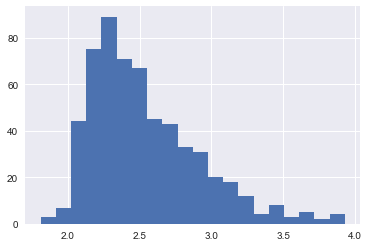

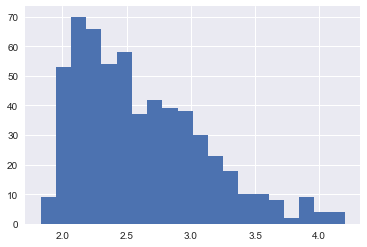

In [6]:
plt.hist(se_2016_renamed.loc[se_2016_renamed['average_ela_proficiency']\
        .notnull(),'average_ela_proficiency'], bins=20)
plt.show()
plt.hist(se_2016_renamed.loc[se_2016_renamed['average_math_proficiency']\
        .notnull(),'average_math_proficiency'], bins=20)
plt.show()

In [8]:
# save the cleaned dataset to CSV
se_2016_renamed.to_csv('data_cleaned/cleaned_explorer.csv', index=False)